In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sn
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import seaborn as sns
from shapely.geometry import Point
import geopandas
from geodatasets import get_path
from shapely.geometry import Polygon

In [9]:
def plot_map(map_data, plot_var, title, figsize=(15, 12), cmap='gist_ncar', makersize = 1):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))

    ax.coastlines(color="0.1")

    plot = map_data.plot(ax=ax, cmap=cmap, column=plot_var, legend=True, markersize=makersize, legend_kwds={"location": "bottom", "pad": 0.05})

    plot.set_title(title)

    plt.show()  # Add this if you want to display plot immediately

In [2]:

colnames_lulc = ['lon', 'lat', 'variable', 'year', 'cohort number', 'cohort source number', 'stand age', 'cohort area ', 
'potential natural vegetaion', 'current vegetation', 'vegetation subtype', 'lc state', 'previous years lc state', 
'fert flag', 'irrg flag', 'till flag', 'disturbance type', 'disturbance month', 'fire return interval',
'th1', 'th2', 'th3', 'th4', 'th5', 'th6', 'country']

colnames_max = ['lon', 'lat', 'variable', 'total land area', 'year', 'total number of cohorts',
                'number of natural cohorts', 'region']

potcohorts = pd.read_csv('/home/smmrrr/land_data_processing/support_files/cruHurtt3.2.1potlulccohrtsr_hurttlf.glb', names = colnames_lulc)
maxcohorts = pd.read_csv('/home/smmrrr/land_data_processing/support_files/cruHurtt3.2.1potmxcohrtsr_hurttlf.glb', names = colnames_max)



In [3]:
region_info = potcohorts[['lon','lat','country']].drop_duplicates().reset_index(drop=True).merge(
maxcohorts[['lon','lat','region']],
    on = ['lon','lat']
)

In [4]:
clm_names = ['lon', 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
         , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
         , 'Nov', 'Dec', 'Area_Name']

In [5]:
nirr = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/tswrf_v11_1700_2021.txt', names = clm_names)
vpr = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/vpr_1700_2021.txt', names = clm_names)
wind = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/wind_1700_2021.txt', names = clm_names)
trange = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/dtr_1700_2021.txt', names = clm_names)
prec = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/precip_1700_2021.txt', names = clm_names)
tair = pd.read_csv('/home/smmrrr/TRENDY_Input_Data/climate_data/tmp_1700_2021.txt', names = clm_names)


In [23]:
CAN_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/CanESM5_ssp245_vpr.csv'
                     , names = clm_names
                     )

BCC_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/BCCxxCSM2xxMR_ssp245_vpr.csv'
                     , names = clm_names
                     )

AWI_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/AWIxxCMxx1xx1xxMR_ssp245_vpr.csv'
                     , names = clm_names
                     )

MICROC6_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/MIROC6_ssp245_vpr.csv'
                     , names = clm_names
                     )

MPIHR_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/MPIxxESM1xx2xxHR_ssp245_vpr.csv'
                     , names = clm_names
                     )

MPILR_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/MPIxxESM1xx2xxLR_ssp245_vpr.csv'
                     , names = clm_names
                     )

MRI_vpr = pd.read_csv('/group/moniergrp/TEM_Large_Ensemble/input_files/global_data/climate/historical/MRIxxESM2xx0_ssp245_vpr.csv'
                     , names = clm_names
                     )


In [24]:
BCC_vpr = BCC_vpr.loc[BCC_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
BCC_vpr_globe = geopandas.GeoDataFrame(
    BCC_vpr, geometry=geopandas.points_from_xy(BCC_vpr.lon, BCC_vpr.lat)
    , crs="EPSG:4326"
)


AWI_vpr = AWI_vpr.loc[AWI_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
AWI_vpr_globe = geopandas.GeoDataFrame(
    AWI_vpr, geometry=geopandas.points_from_xy(AWI_vpr.lon, AWI_vpr.lat)
    , crs="EPSG:4326"
)


MICROC6_vpr = MICROC6_vpr.loc[MICROC6_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
MICROC6_vpr_globe = geopandas.GeoDataFrame(
    MICROC6_vpr, geometry=geopandas.points_from_xy(MICROC6_vpr.lon, MICROC6_vpr.lat)
    , crs="EPSG:4326"
)


MPIHR_vpr = MPIHR_vpr.loc[MPIHR_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
MPIHR_vpr_globe = geopandas.GeoDataFrame(
    MPIHR_vpr, geometry=geopandas.points_from_xy(MPIHR_vpr.lon, MPIHR_vpr.lat)
    , crs="EPSG:4326"
)


MPILR_vpr = MPILR_vpr.loc[MPILR_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
MPILR_vpr_globe = geopandas.GeoDataFrame(
    MPILR_vpr, geometry=geopandas.points_from_xy(MPILR_vpr.lon, MPILR_vpr.lat)
    , crs="EPSG:4326"
)


MRI_vpr = MRI_vpr.loc[MRI_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
MRI_vpr_globe = geopandas.GeoDataFrame(
    MRI_vpr, geometry=geopandas.points_from_xy(MRI_vpr.lon, MRI_vpr.lat)
    , crs="EPSG:4326"
)


In [20]:
CAN_vpr_globe = CAN_vpr.loc[CAN_vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
CAN_vpr_globe = geopandas.GeoDataFrame(
    CAN_vpr_globe, geometry=geopandas.points_from_xy(CAN_vpr_globe.lon, CAN_vpr_globe.lat)
    , crs="EPSG:4326"
)

In [10]:
nirr_globe = nirr.loc[nirr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
nirr_globe = geopandas.GeoDataFrame(
    nirr_globe, geometry=geopandas.points_from_xy(nirr_globe.lon, nirr_globe.lat)
    , crs="EPSG:4326"
)
vpr_globe = vpr.loc[vpr['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
vpr_globe = geopandas.GeoDataFrame(
    vpr_globe, geometry=geopandas.points_from_xy(vpr_globe.lon, vpr_globe.lat)
    , crs="EPSG:4326"
)
wind_globe = wind.loc[wind['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
wind_globe = geopandas.GeoDataFrame(
    wind_globe, geometry=geopandas.points_from_xy(wind_globe.lon, wind_globe.lat)
    , crs="EPSG:4326"
)
trange_globe = trange.loc[trange['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
trange_globe = geopandas.GeoDataFrame(
    trange_globe, geometry=geopandas.points_from_xy(trange_globe.lon, trange_globe.lat)
    , crs="EPSG:4326"
)
prec_globe = prec.loc[prec['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
prec_globe = geopandas.GeoDataFrame(
    prec_globe, geometry=geopandas.points_from_xy(prec_globe.lon, prec_globe.lat)
    , crs="EPSG:4326"
)
tair_globe = tair.loc[tair['year']>=1900].groupby(['lat', 'lon'])['average'].mean().reset_index()
tair_globe = geopandas.GeoDataFrame(
    tair_globe, geometry=geopandas.points_from_xy(tair_globe.lon, tair_globe.lat)
    , crs="EPSG:4326"
)



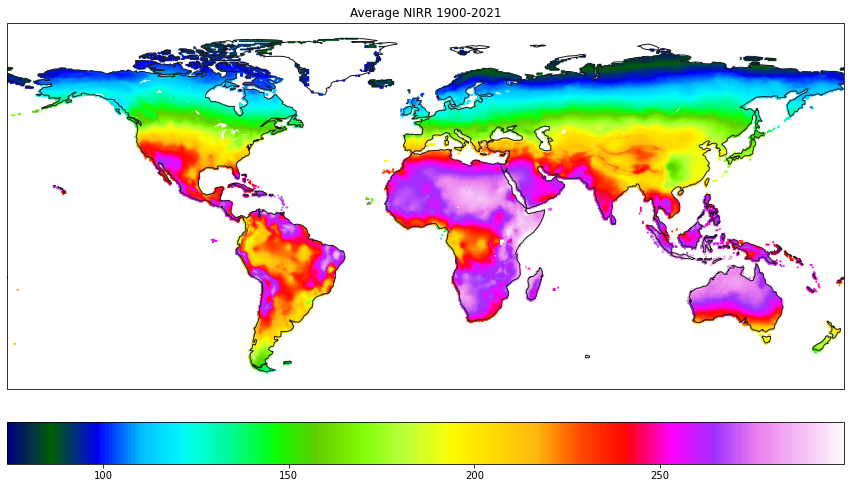

In [11]:
plot_map(nirr_globe, 'average', 'Average NIRR 1900-2021')

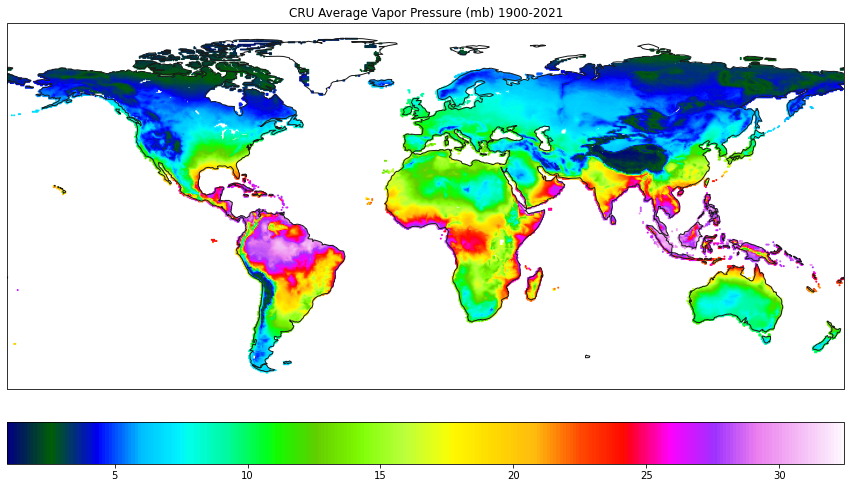

In [22]:
plot_map(vpr_globe, 'average', 'CRU Average Vapor Pressure (mb) 1900-2021')

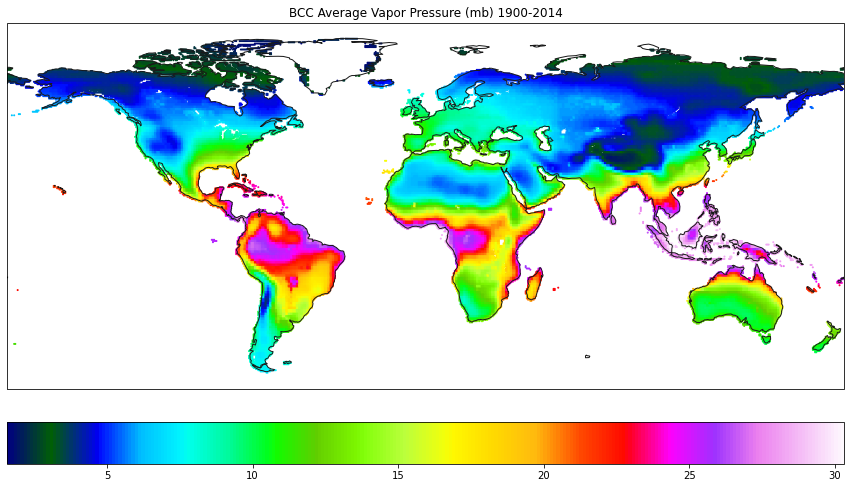

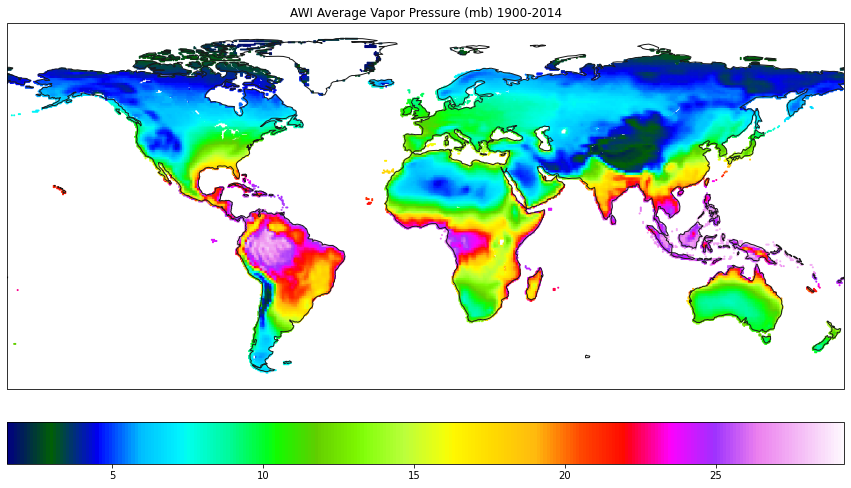

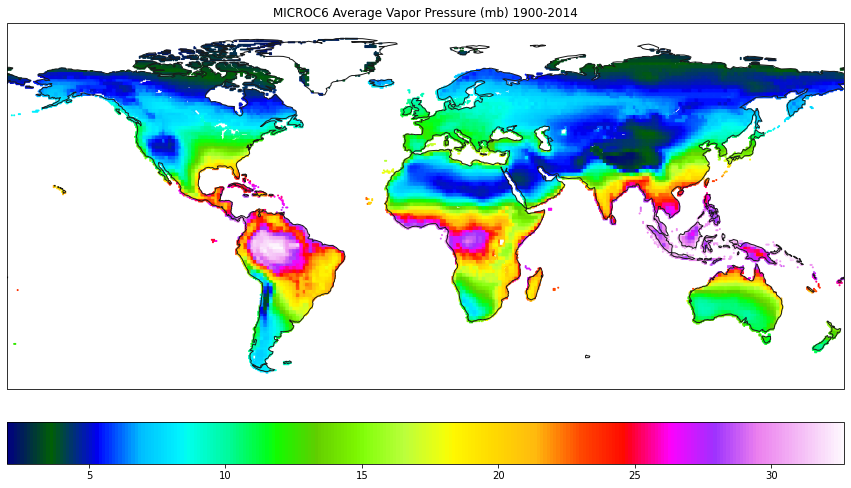

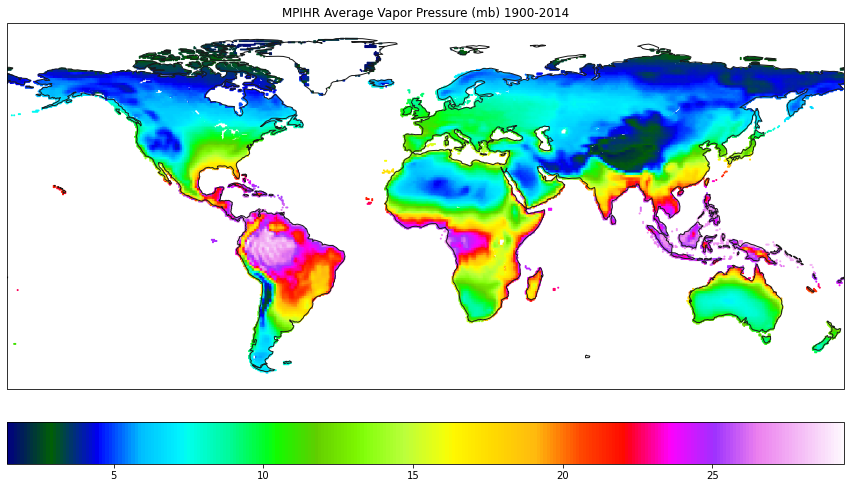

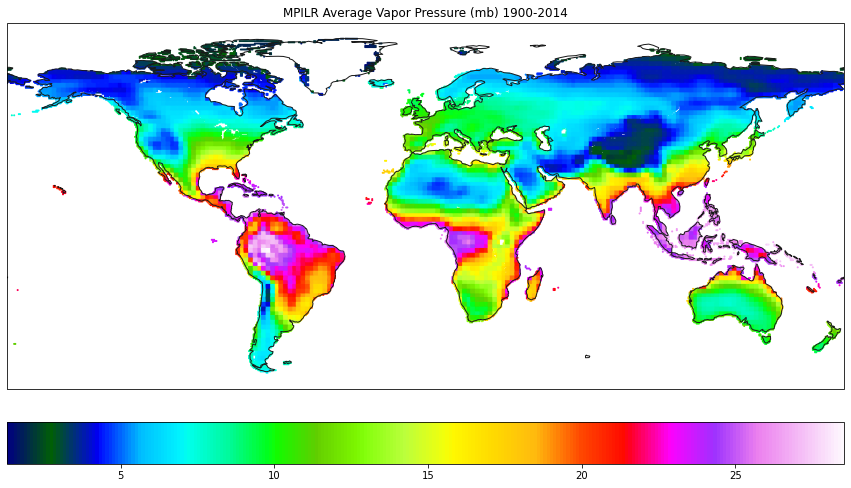

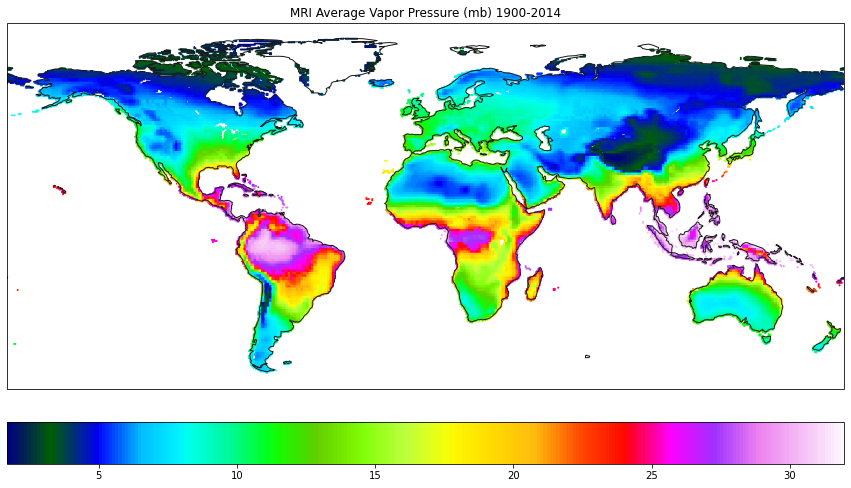

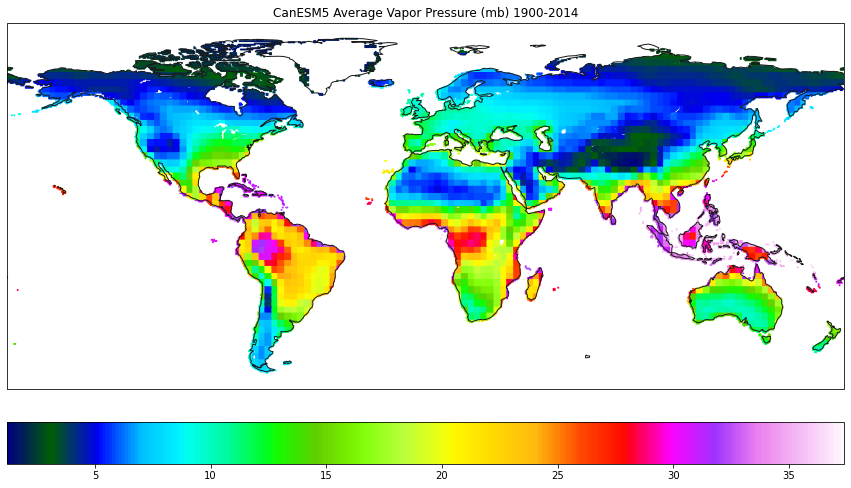

In [25]:
plot_map(BCC_vpr_globe, 'average', 'BCC Average Vapor Pressure (mb) 1900-2014')
plot_map(AWI_vpr_globe, 'average', 'AWI Average Vapor Pressure (mb) 1900-2014')
plot_map(MICROC6_vpr_globe, 'average', 'MICROC6 Average Vapor Pressure (mb) 1900-2014')
plot_map(MPIHR_vpr_globe, 'average', 'MPIHR Average Vapor Pressure (mb) 1900-2014')
plot_map(MPILR_vpr_globe, 'average', 'MPILR Average Vapor Pressure (mb) 1900-2014')
plot_map(MRI_vpr_globe, 'average', 'MRI Average Vapor Pressure (mb) 1900-2014')
plot_map(CAN_vpr_globe, 'average', 'CanESM5 Average Vapor Pressure (mb) 1900-2014')

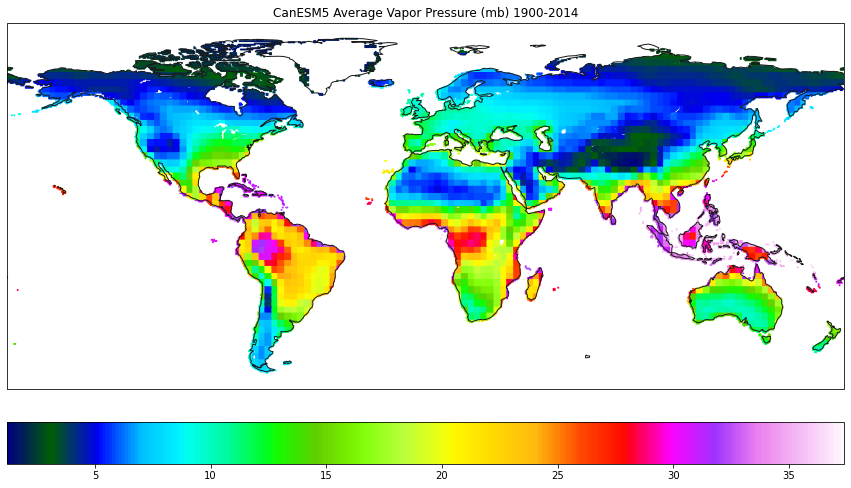

In [21]:
plot_map(CAN_vpr_globe, 'average', 'CanESM5 Average Vapor Pressure (mb) 1900-2014')

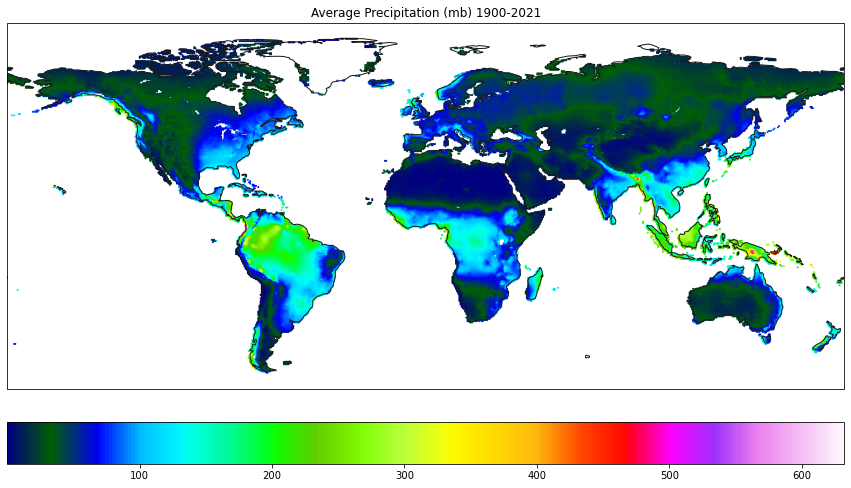

In [14]:
plot_map(prec_globe, 'average', 'Average Precipitation (mb) 1900-2021')

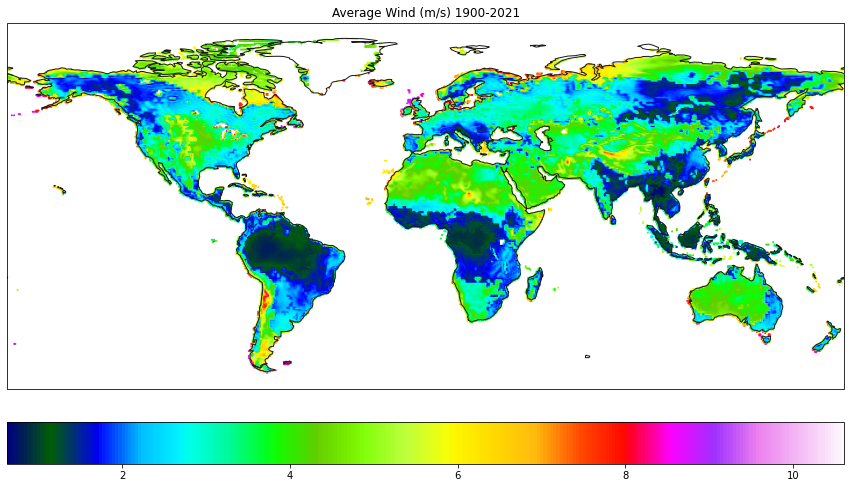

In [15]:
plot_map(wind_globe, 'average', 'Average Wind (m/s) 1900-2021')

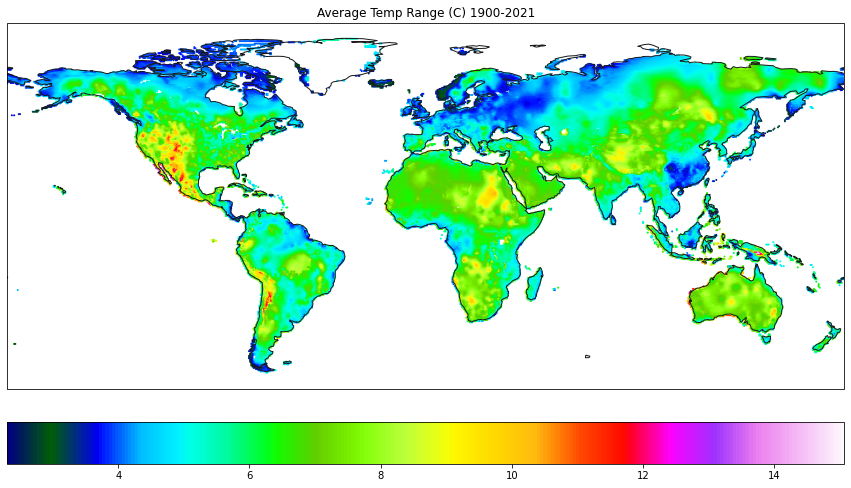

In [16]:
plot_map(trange_globe, 'average', 'Average Temp Range (C) 1900-2021')

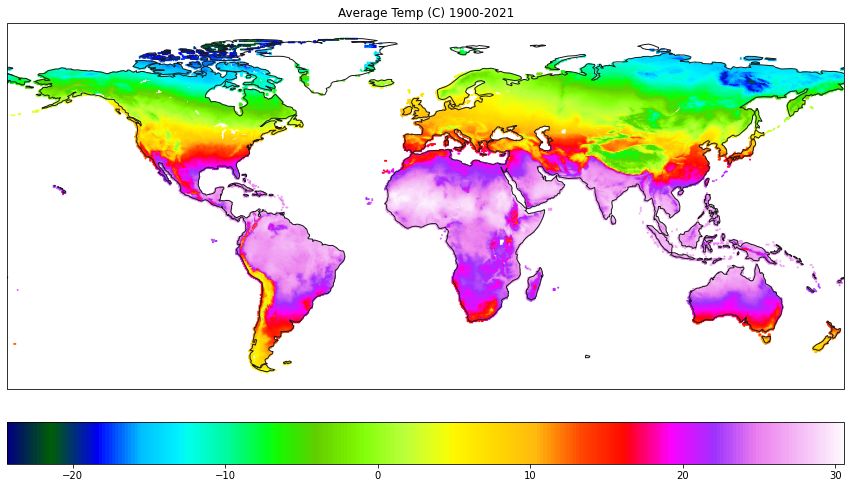

In [17]:
plot_map(tair_globe, 'average', 'Average Temp (C) 1900-2021')

In [4]:
# nirr = pd.read_csv('/home/smmrrr//TRENDY_Input_Data/climate_data/tswrf_v11_1700_2021.txt', names = clm_names)

In [37]:
nirr=nirr.merge(region_info, on = ['lon','lat'])

In [43]:
region_info.region.unique()

array([' Asia', ' North_America', ' Australia', ' South_America',
       ' Africa', ' Europe', ' europe', ' Europea', ' AusEuropetralia'],
      dtype=object)

In [39]:
region_info.country.unique()

array([' Russia', ' United_States_of_America', ' New_Zealand', ' Tonga',
       ' Canada', ' Mexico', ' Guatemala', ' Ecuador', ' El_Salvador',
       ' Honduras', ' Belize', ' Nicaragua', ' Costa_Rica', ' Cuba',
       ' Panama', ' Peru', ' Colombia', ' Bahamas', ' Jamaica', ' Chile',
       ' Haiti', ' Brazil', ' Argentina', ' Venezuela', ' Greenland',
       ' Dominican_Republic', ' United_Kingdom', ' Bolivia',
       ' Netherland_Antilles', ' Puerto_Rico', ' Saint_Kitts_and_Nevis',
       ' Paraguay', ' Trinidad_and_Tobago', ' Grenada', ' France',
       ' Antigua_and_Barbuda', ' Saint_Vincent_and_the_Grenadines',
       ' Dominica', ' Guyana', ' Saint_Lucia', ' Barbados', ' Uruguay',
       ' Suriname', ' French_Guiana', ' Cape_Verde', ' Iceland', ' Spain',
       ' Senegal', ' Mauritania', ' Western_Sahara', ' Portugal',
       ' Gambia', ' Guinea-Bissau', ' Guinea', ' Sierra_Leone',
       ' Morocco', ' Mali', ' Liberia', ' Ireland',
       " Cote_d'Ivoire_(Ivory_Coast)", ' Alge

<Axes: xlabel='year'>

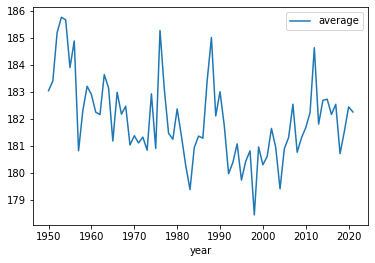

In [45]:
nirr.loc[(nirr['year'].between(1950, 2022))
        &(nirr['country']==' United_States_of_America')].groupby('year')['average'].mean().reset_index().plot(x = 'year', y = 'average')

<Axes: xlabel='year'>

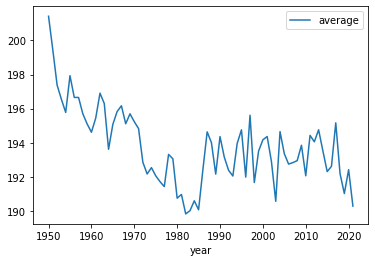

In [46]:
nirr.loc[(nirr['year'].between(1950, 2022))
        &(nirr['country']==' China')].groupby('year')['average'].mean().reset_index().plot(x = 'year', y = 'average')

<Axes: xlabel='year'>

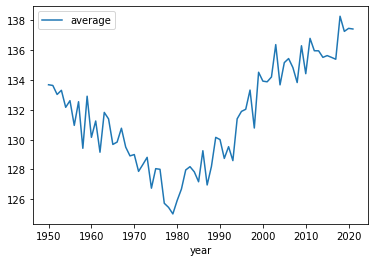

In [47]:
nirr.loc[(nirr['year'].between(1950, 2022))
        &(nirr['region']==' Europe')].groupby('year')['average'].mean().reset_index().plot(x = 'year', y = 'average')

In [7]:
nirr['yy_average'] = nirr['average'] - nirr.groupby(['lon','lat'])['average'].shift() 

<Axes: xlabel='year'>

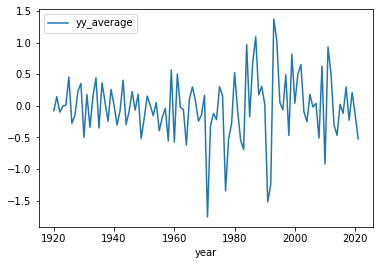

In [13]:
nirr.loc[nirr['year'].between(1920, 2022)].groupby('year')['yy_average'].mean().reset_index().plot(x = 'year', y = 'yy_average')

<Axes: xlabel='year'>

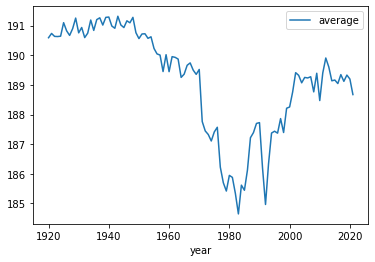

In [16]:
nirr.loc[nirr['year'].between(1920, 2022)].groupby('year')['average'].mean().reset_index().plot(x = 'year', y = 'average')

<Axes: xlabel='year'>

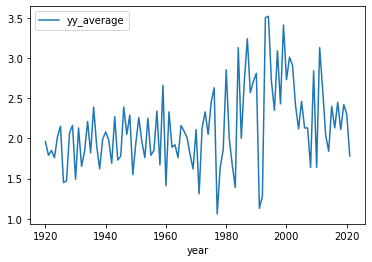

In [14]:
nirr.loc[nirr['year'].between(1920, 2022)].groupby('year')['yy_average'].quantile(.75).reset_index().plot(x = 'year', y = 'yy_average')

<Axes: xlabel='year'>

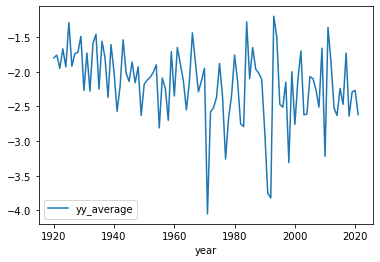

In [15]:
nirr.loc[nirr['year'].between(1920, 2022)].groupby('year')['yy_average'].quantile(.25).reset_index().plot(x = 'year', y = 'yy_average')

In [24]:
compare = nirr.loc[nirr['year'].between(1970, 1990)].groupby(['lon','lat'])['average'].mean().reset_index().merge(
nirr.loc[nirr['year'].between(1920, 1940)].groupby(['lon','lat'])['average'].mean().reset_index()
    , on = ['lon','lat']
,suffixes = ('_1970_1990','_1920_1940')
)

compare['nirr_diff'] = compare['average_1970_1990'] - compare['average_1920_1940']

In [25]:
map_data = geopandas.GeoDataFrame(
    compare, geometry=geopandas.points_from_xy(compare.lon, compare.lat)
    , crs="EPSG:4326"
)

map_data

lon   lat  average_1970_1990  average_1920_1940  nirr_diff  \
0     -180.0  65.0         101.619524         102.854286  -1.234762   
1     -180.0  65.5          99.627619         101.120000  -1.492381   
2     -180.0  66.0          96.823333          98.983333  -2.160000   
3     -180.0  66.5          94.815714          97.466667  -2.650952   
4     -180.0  67.0          93.454762          96.009048  -2.554286   
...      ...   ...                ...                ...        ...   
62603  179.5  67.5          94.416190          96.651905  -2.235714   
62604  179.5  68.0          94.050000          95.451429  -1.401429   
62605  179.5  68.5          94.513333          95.036667  -0.523333   
62606  179.5  70.5          88.952857          89.353333  -0.400476   
62607  179.5  71.0          88.022857          88.350000  -0.327143   

                          geometry  
0      POINT (-180.00000 65.00000)  
1      POINT (-180.00000 65.50000)  
2      POINT (-180.00000 66.00000)  
3      POINT (-180.00000 66.50000)  
4      POINT (-180.00000 67.00000)  
...                            ...  
62603   POINT (179.50000 67.50000)  
62604   POINT (179.50000 68.00000)  
62605   POINT (179.50000 68.50000)  
62606   POINT (179.50000 70.50000)  
62607   POINT (179.50000 71.00000)  

[62608 rows x 6 columns]

Text(0.5, 1.0, 'Difference in nirr 1970-1990 minus 1920-1940')

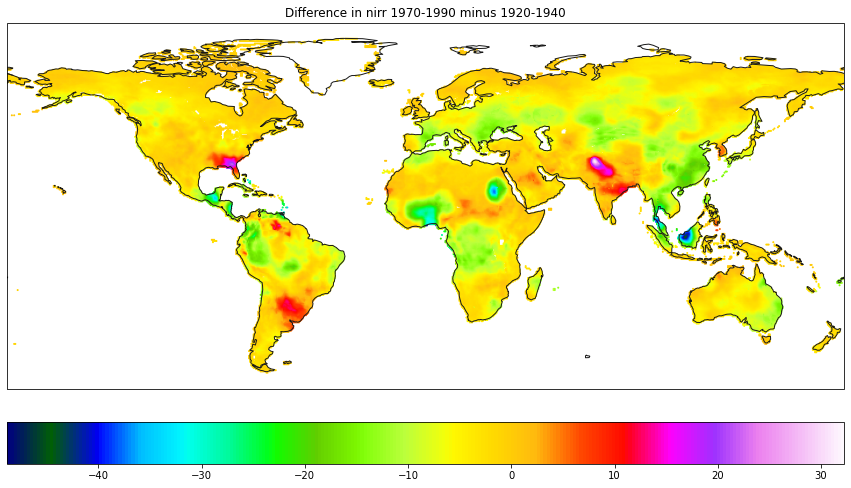

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize = (15, 12)
                      ,subplot_kw=dict(projection=ccrs.PlateCarree()))

axs.coastlines(color="0.1")
# axs[1].coastlines(color="0.1")


plot0 = map_data.plot(ax = axs 
                                         ,cmap = 'gist_ncar'
                                         , column = 'nirr_diff', legend = True, 
                                         # vmin = 0, vmax = 20000, 
                                                          markersize = 1,
                       # legend_kwds={'bbox_to_anchor': (1.1, 1)  }                
                      legend_kwds={ "location":"bottom" , "pad":0.05}
                                        )

plot0.set_title('Difference in nirr 1970-1990 minus 1920-1940')

In [18]:
nirr.Area_Name.unique()


array([' USA48'], dtype=object)